In [1]:
import h5py
import pandas as pd
import numpy as np
from typing import Union
import matplotlib.pyplot as plt
import cv2 as cv
import os
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def import_blobs(grp: Union[h5py.Group, None], color: str) -> Union[pd.DataFrame, None]:
    if grp is None:
        return None

    return pd.DataFrame({"x": grp[f"{color}/x"][:], "y": grp[f"{color}/y"][:]})


def process_blobs(path_to_h5, overlap_cfx_cutoff):
    dfs = []
    with h5py.File(path_to_h5) as h5:
        for grp in h5:
            scores = h5[f"{grp}/scores"][:]
            blob_paths = [f"{grp}/blobs/{blob}" for blob in h5[f"{grp}/blobs/"]]

            assert len(scores) == len(blob_paths)
            for blob_path, score in zip(blob_paths, scores):
                if score < overlap_cfx_cutoff:
                    continue
                blobs1 = import_blobs(h5[blob_path], "green")
                blobs1["color"] = "green"
                blobs1["cell"] = blob_path


                blobs2 = import_blobs(h5[blob_path], "red")
                blobs2["color"] = "red"
                blobs2["cell"] = blob_path

                dfs.append(pd.concat([blobs1, blobs2]))

    return pd.concat(dfs)

def process_contours(path, overlap_cfx_cutoff):
    data = []
    with h5py.File(path) as h5:
        for grp in h5:
            scores = h5[f"{grp}/scores"][:]
            labels = h5[f"{grp}/contours/label"][:]
            x = h5[f"{grp}/contours/x"][:]
            y = h5[f"{grp}/contours/y"][:]

            imgs = {}
            for i, path, in enumerate(h5[f"{grp}/imgs/"]):
                if not path.startswith("000_") and scores[i - 1] >= overlap_cfx_cutoff:
                    imgs[i - 1] = (path, h5[f"{grp}/imgs/{path}"][:])
            
            df = pd.DataFrame({"cell": [grp] * len(labels), "label": labels, "x": x, "y": y})
            for (cell, cid), dff in df.groupby(["cell", "label"]):
                if not cid in imgs:
                    continue
                path, img = imgs[cid]

                yshape, xshape = img.shape[0:2]
                xshape += 1
                yshape += 1

                m = np.zeros([yshape, xshape], dtype=np.uint8)

                x = dff["x"].astype(int)
                y = dff["y"].astype(int)

                m[y, x] = 1

                M = cv.moments(m)

                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                data.append([cell, path, cx, cy])
    
    return pd.DataFrame(data, columns=["cell", "centroid_id", "centroid_x", "centroid_y"])

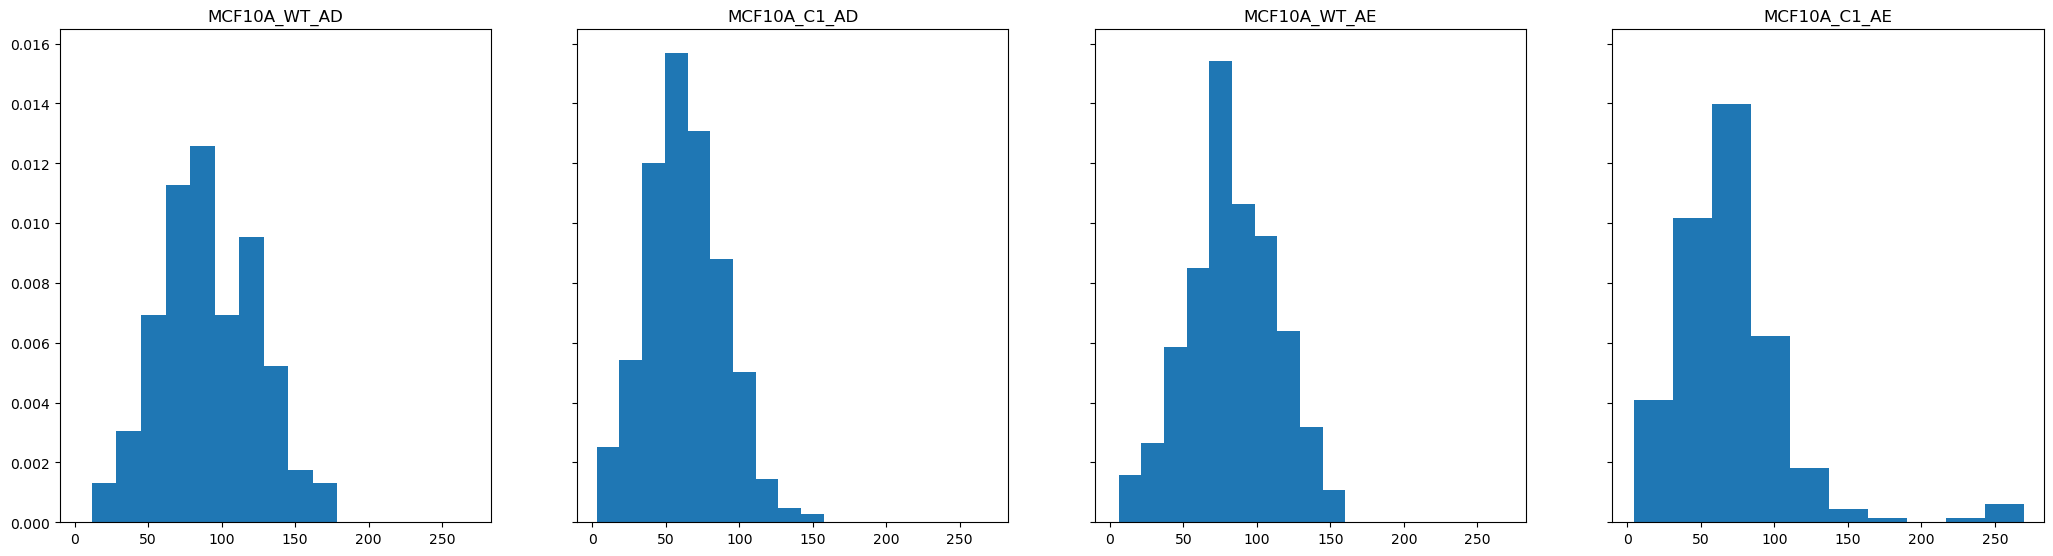

In [3]:
files = [
    "../data/output/fish/MCF10A_WT_AD_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_C1_AD_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_WT_AE_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_C1_AE_segmented_nuclei_with_blobs.h5",
    
]

fig, axs = plt.subplots(1, len(files), figsize=(len(files) * 6.4, 6.4), sharex=True, sharey=True)

for f, ax in zip(files, axs):
    blobs = process_blobs(f, 0.95)
    centroids = process_contours(f, 0.95)
    dfs = []
    for _, row in centroids.iterrows():
        cell, cid = row["cell"], row["centroid_id"]
        cell = f"{cell}/blobs/{cid}"
        x, y = row["centroid_x"], row["centroid_y"]
        df = blobs[blobs["cell"] == cell].copy()
        df["dist"] = np.sqrt(np.power(df["x"] - x, 2) + np.power(df["y"] - y, 2))
        dfs.append(df)

    df = pd.concat(dfs)
    ax.hist(df["dist"], density=True)
    ax.set(title=os.path.basename(f).removesuffix("_segmented_nuclei_with_blobs.h5"))

fig.savefig("/tmp/fish_radial_positioning_hist.svg")

In [4]:
files = [
    "../data/output/fish/MCF10A_WT_AD_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_C1_AD_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_WT_AE_segmented_nuclei_with_blobs.h5",
    "../data/output/fish/MCF10A_C1_AE_segmented_nuclei_with_blobs.h5",
    
]

with PdfPages("/tmp/fish_centroids.pdf") as pdf:
    with h5py.File(files[0]) as h5:
        centroids = process_contours(files[0], 0.95)
        for grp in h5:
            imgs = {}
            scores = h5[f"{grp}/scores"][:]
            for i, path in enumerate(h5[f"{grp}/imgs/"]):
                if not path.startswith("000_"):
                    imgs[i - 1] = (path, h5[f"{grp}/imgs/{path}"][:], scores[i - 1])

            fig, axs = plt.subplots(1, len(imgs), figsize=(6.4 * len(imgs), 6.4))
            if len(imgs) == 1:
                axs = [axs]
            for (path, img, score), ax in zip(imgs.values(), axs):
                ax.imshow(img)

                centroid = centroids[(centroids["cell"] == grp) & (centroids["centroid_id"] == path.split("/")[-1])]

                ax.scatter(centroid["centroid_x"], centroid["centroid_y"], s=20, color="white")
                ax.set(title=str(score))

            fig.suptitle(grp)
            fig.tight_layout()
            pdf.savefig(fig, dpi=300)
            plt.close(fig)

    